# 📖Background


The board of a human capital department of a large corporation is worried about the relatively high turnover, and the analytics team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, the team can present findings along with ideas on how to attack the problem.

# Recomendations

**Two different strategies:** 

Workers at the company for 6 years or less:
- Monitoring workers' satisfaction and review score is crucial in identifying turnover. Performance review above the 75th percentile and satisfaction below 50 % are critical regions for turnover.
- Here promotions offer a way of retaining workers. Since no evidence was found to suggest that review scores influences promotions, giving more importance to these metrics when choosing who to be promoted can reduce turnover.
- Despite skills, it is important that the employees fit with the company’s organizational culture. 
- Employees need to be acknowledged and given praise when due.
- Show appreciation whenever applicable and create a positive work environment that employees can succeed in.
- Employees who feel desired and respected are more likely to stay with the company.

Workers averaging more than 185 hours a month:
- As the years pass, workers acumulate responsibilities, increasing the time needed to complete their duties. Once they start to work more than 185 hours month countermeasures should be applied to reduce the time spent working. Here monitoring workers' satisfaction won't help.
- Once workers pass this threshold one countermeasure to be applied could be to share the overwhelming responsibilities of these workers with their colleagues. The accumulation of projects does not seem to increase turnover as long as working hours stay below 185 hours a month.
- Since giving more projects to workers does not increase turnover, splitting these workers' responsibilities with their colleagues whenever possible, reducing their schedules, could be an option to keep workers from working more than 185 hours a month.
- In today’s society, a flexible work schedule is highly desirable. In fact, studies have shown that a flexible work arrangement has a positive impact on employee retention.
- Allowing employees to choose their work time and providing a flexible work schedule gives employees the ability to balance their work and personal life and, hence, improves employee satisfaction.


# Set up

## Install and import 

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
import seaborn as sns 
import statsmodels 

from collections import defaultdict
import matplotlib.ticker as mtick
import matplotlib
path = './data/employee_churn_data.csv'

df = pd.read_csv(path)

## Functions

In [ ]:
from statsmodels.stats.proportion import proportions_ztest as pzt

def diff_of_means(data_1, data_2):
    """
    Difference in means of two arrays.
    """
    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1)-np.mean(data_2)

    return diff


def proportion(data_0, data_1):
    """Compute fraction of Democrat yea votes."""
    frac = np.sum(data_0) / len(data_0)
    return frac


def draw_perm_reps(data_0, data_1, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
    data = np.concatenate((data_0,data_1))
    for i in range(size):
        # Permute the concatenated array: permuted_data
        permuted_data = np.random.permutation(data)

        # Split the permuted array into two: perm_sample_1, perm_sample_2
        perm_sample_0 = permuted_data[:len(data_0)]
        perm_sample_1 = permuted_data[len(data_0):]
        
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_0,perm_sample_1)

    return perm_replicates


def CohenEffectSize(group1, group2, paired =False):
    """Computes Cohen's effect size for two groups.

    group1 : Series or DataFrame
    group2 : Series or DataFrame
        paired : bool (if each row correspond to the same subject in different time 
              eg: scores in math ~A/B test)  

    returns: float if the arguments are Series;
             Series if the arguments are DataFrames

    """
    diff = group1.mean() - group2.mean()

    var1,var2 = group1.var() , group2.var()
    n1, n2 = len(group1), len(group2)

    if len(group1)==len(group2):
        # equal sized groups
        pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    else:
      # unequal sized groups
        pooled_var = ((n1-1) * var1 + (n2-1) * var2) / (n1 + n2-2) 
    d = diff / np.sqrt(pooled_var)
    if paired == False :
        d=d
    else:
        r,p = stats.pearsonr(x,y)
        d= d / np.sqrt(1-r)
    return d

def ticks_percent(data, **kws):
    ax = plt.gca() 
    n = len(data)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))



## The data 

In [ ]:
#Transform the data 

# chnage left to make easier legends in visualizations
df["left_label"]=df.left
df.left_label.replace({"yes":"Left" , "no": "Stayed"}, inplace=True)

# Make left binary, to allow for calculating proportion 
df.left.replace({"yes":1 , "no": 0}, inplace=True)

# Chaging data type. 
df["tenure"]=df.tenure.astype("int")

# Memory is not an issue but it is a good practise to use category 
df["department"]=df.department.astype("category")
df["salary"]=df.salary.astype("category")
df["left_label"]=df.left_label.astype("category")

# Create variables
df["4-5"] = df.projects.isin([4,5])
df["reward"]= df.promoted+df.bonus
df.loc[df.reward==2,"reward"]= 1


In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   department     9540 non-null   category
 1   promoted       9540 non-null   int64   
 2   review         9540 non-null   float64 
 3   projects       9540 non-null   int64   
 4   salary         9540 non-null   category
 5   tenure         9540 non-null   int64   
 6   satisfaction   9540 non-null   float64 
 7   bonus          9540 non-null   int64   
 8   avg_hrs_month  9540 non-null   float64 
 9   left           9540 non-null   int64   
 10  left_label     9540 non-null   category
 11  4-5            9540 non-null   bool    
 12  reward         9540 non-null   int64   
dtypes: bool(1), category(3), float64(3), int64(6)
memory usage: 708.8 KB


None

In [ ]:
display(df.describe(include=["float"]))

,review,satisfaction,avg_hrs_month
count,9540.000000,9540.000000,9540.000000
mean,0.651826,0.504645,184.661571
std,0.085307,0.158555,4.144831
min,0.310000,0.000000,171.374060
25%,0.592884,0.386801,181.472085
50%,0.647456,0.500786,184.628796
75%,0.708379,0.622607,187.728708
max,1.000000,1.000000,200.861656


In [ ]:
display(df.describe(include="category"))

,department,salary,left_label,tenure_cut
count,9540,9540,9540,9540
unique,10,3,2,4
top,sales,medium,Stayed,5-6
freq,1883,6611,6756,4136


- No missing value was founded 
- No outliers, (avg_hrs_month is explained by tenure)
- Variables range makes since given the context
- Data is ready for analysis.

# Report

The main goal of this report is to help reduce the number of employees leaving the company.

Usually, there are two ways of leaving : 
* **Voluntary** : When the person decides to leave 
* **Involuntary** : When the person is fired

Further analysis including this information would be recommendable.

Apart from these, another very important measure to track is the number of high-performance workers that are leaving. 

To assess this problems I'll be using the turnover rate calculated for each subset as a percentage of people that are leaving.

This report will explore how different the turnover rate is across the company.

Having a high turnover rate means your culture might be toxic, or your employees don’t feel fulfilled working at your company.

High employee turnover can have far-reaching effects on an employer, including:

- Decreasing overall productivity within the organization
    - Train new hires who need a significant amount of time to be able to tackle a full workload.
- Increasing costs of hiring and training new employees
- Putting extra strain on remaining employees to take up the departing employees’ workload
- Decreasing employee trust in the organization
- Weakening company culture and morale
- Causing strain on the relationships among employees and between employees and managers
- **Brand image →** *For example, working in the fast-food industry is seen as undesirable due to its notoriously high turnover rates.*

The turnover rate for the whole company was **29.1%**. An interpretation of this value requires more information. 


This value is expected to be different across industries, countries and, among others, the type of calculation.

In the 2021 , the separation rate  (a.k.a. turnover rate) was **3.8 %**, but that number drops to **2.6 %** when considering only voluntary turnover (quits), and just **0.9 %** when considering involuntary turnover (layoffs and discharges)
<br>*Note : Not seasonally adjusted data for Dec 2021 according to [Bureau of Labor Statistics](https://www.bls.gov/news.release/archives/jolts_02012022.pdf) report*


## Departments

This company has 10 departments.
- Sales is the biggest one representing almost **20 %** of the whole company.
- Operations, Engineering, and Retail have around **16 %** each. 
- Support and Marketing around **8 %**.
- Admin and Finance  have **5 %** 
- Logistics and IT just under **4 %**.


**Figure 1** Shows turnover rate for each department.

IT, Logistics, Retail and Marketing departments have the highest turnover rates, passing **30 %**.
<br>The Finance department was the least affected with just **26.9%** of their employees leaving.


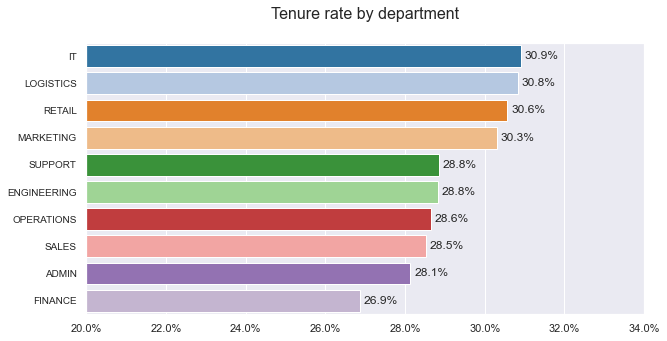

Figure 1


In [ ]:
sns.set(rc= {"figure.figsize": (10, 5)})
data = df.groupby(["department"]).mean()[["left"]].rename(columns={"left":"Turnover rate"}).reset_index().sort_values(by="Turnover rate",ascending=False)
text = [x.upper() for x in list(data.iloc[:,0])]


g = sns.barplot(data = data, 
                orient="h",
                y="department", 
                x="Turnover rate",
                palette="tab20",
                order=list(data.sort_values(by="Turnover rate", ascending=False).iloc[:,0]))

for i in range(10):
  value= data.iloc[i ,1]
  g.text( value+0.001, i+0.1,
           f"{value:.1%}"
      
  )
plt.title('Tenure rate by department\n', fontdict={"size":16})
plt.xlabel('')
plt.ylabel('')
g.set_xlim([0.2, 0.34])
g.xaxis.set_major_formatter(mtick.PercentFormatter(1)) 
g.set_yticklabels(text, fontdict=dict(size=10, family = "arial"))
plt.show()
print('\033[1m' + 'Figure 1' + '\033[0m')

The variation in turnover rate is bigger when we breakdown by tenure (the number of years an employee has been with the company)
<br>This variable shows employees at the company for 2 to 12 years.
Half of them have worked for 6 years or less.

Looking at **Figure 2** bellow, the biggest turnover rate is among workers at the company for 2 years, but looking at the chart on the left we can see that there are only 3 workers in that category. To extract knowledge from tenure 2, we would need more data.

This illustrates the need for presenting the metrics along with the p-value.
No prior knowledge of hypothesis testing is needed to continue.
In the context of this report, a p-value below 0.05 should be considered a significant result. 
<br>If the p-value is above 0.05 it means we need more data. 

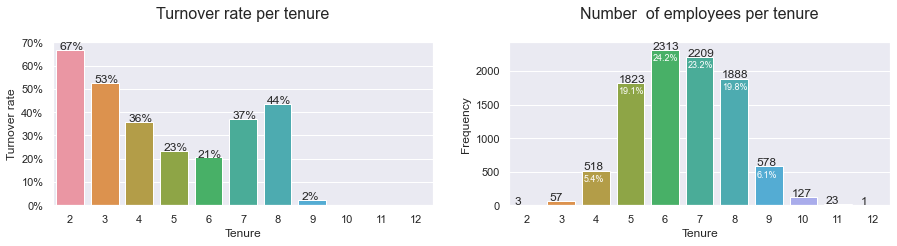

Figure 2


In [ ]:
sns.set(rc= {"figure.figsize": (15, 3)})
fig, axes = plt.subplots(1, 2)
data = df.groupby(["tenure"]).mean()[["left"]].rename(columns={"left":"Turnover rate"}).reset_index()
bar=sns.barplot(data=data, x="tenure",y="Turnover rate", ax=axes[0])
for i in range(2,10):
  value= data.loc[data.tenure==i ,"Turnover rate"].values[0]
  bar.text( i-2.3, value,
           str(f"{value:.0%}")
      
  )
    
bar.set_title('Turnover rate per tenure\n', fontdict={"size":16})
bar.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
bar.set_xlabel('Tenure')
#______________
data = df.groupby(["tenure"]).count()[["left"]].rename(columns={"left":"Frequency"}).reset_index()
bar1=sns.barplot(data=data, x="tenure",y="Frequency",ax=axes[1])
for i in range(2,13):
  value= data.loc[data.tenure==i ,"Frequency"].values[0]
  bar1.text( i-2.35, value+10,
           str(value)
      
  )
for i in range(4,10):
  value= data.loc[data.tenure==i ,"Frequency"].values[0] 
  bar1.text( i-2.35, value-160,
           str(f"{value/len(df):.1%}"),
              fontdict=dict(color="white", size=9)
      
  )

bar1.set_title('Number  of employees per tenure\n', fontdict={"size":16})
bar1.set_xlabel('Tenure')



plt.show()

print('\033[1m' + 'Figure 2' + '\033[0m')

<br> Workers at the company for 3 years have a turnover rate **21** percentage points above the rest of their colleagues. 

No one at the company for a decade or over has decided to leave.

Onwards, the report will focus only on workers at the company between 3 and 9 years, accounting for 98 % of the company.  

In [ ]:
print('\033[1m' + 'Turnover rate per tenure\n' + '\033[0m')
np.random.seed(22)
cols=defaultdict(list)

for i in range(2,10):

    # data0 represents set tenure and data1 the rest of the company
    data0=df.loc[df.tenure==i, "left"]
    data1=df.loc[df.tenure!=i, "left"]

    # Turnover rate for each group as well as the difference
    obs=data0.mean()
    diff=obs- data1.mean()
    repre  = len(data0) / len(df)
    data = np.concatenate((data0,data1))
    perm_replicates = draw_perm_reps(data0, data1, proportion, 10000)
    
    #p-value is calculated depending on the direction
    if obs > data.mean():
        p = np.sum(perm_replicates >= obs) / len(perm_replicates)
    else:
        p = np.sum(perm_replicates <= obs) / len(perm_replicates)

    # feed the results into the dictionary

    cols["Tenure"].append(i)
    cols["p-value"].append(round(p,3))
    cols["Turnover rate"].append(f"{data0.mean():.1%}")
    cols["Turnover rate for others"].append(f"{data1.mean():.1%}")
    cols["difference"].append(f"{diff:+.1%}")
    cols["Representation"].append(f"{repre:.2%}")

# use the dictionary to create a DataFrame
display(pd.DataFrame(cols).set_index("Tenure"))
print('\033[1m' + 'Figure 3' + '\033[0m')

Turnover rate per tenure



,p-value,Turnover rate,Turnover rate for others,difference,Representation
Tenure,,,,,
2,0.205,66.7%,29.2%,+37.5%,0.03%
3,0.000,52.6%,29.0%,+23.6%,0.60%
4,0.001,35.9%,28.8%,+7.1%,5.43%
5,0.000,23.5%,30.5%,-7.1%,19.11%
6,0.000,20.7%,31.9%,-11.2%,24.25%
7,0.000,37.3%,26.7%,+10.5%,23.16%
8,0.000,43.6%,25.6%,+18.0%,19.79%
9,0.000,2.4%,30.9%,-28.5%,6.06%


Figure 3


*Note: p-value is a 1-sided test that turnover rate does not differ by tenure, iterated 10,000 times ($\alpha$ =0.05)*

According to a report on tenure in 2020 from the [Bureau of Labor Statistics](https://www.bls.gov/news.release/tenure.nr0.htm), median tenure in the US was 4.1 years. This is how long we expect a worker to stay on the same job. 

The median in this report is 7 years.

Although tenure 3 has the highest turnover, it only accounts for 0.6 % of all employees.
If the mission is reducing turnover globally, the biggest concern is around the workers at the company for 7 or 8 years. 

<br> These two groups combined represent  **42 %** of the total employees. 
<br>With **40 %** of these workers leaving, compared to **20.9 %** for the rest of the company. 

60 % of the workers that left belong to this group.

If we don't account for tenures 7 or 8, the turnover rate is 20%.

This report will explore several reasons why someone might decide to leave. 

Perhaps they didn't feel appreciated at the company by not getting the promotion they <br>deserved, the bonus they craved, or the salary they wanted. 

Another reason might be that they are overwhelmed by the number of responsibilities including being involved in too many projects or working long hours.   

Apart from those, there are all of the factors not represented in the data.
Those can take many forms including better pay and/or better conditions, better benefits, among others.




## Satisfaction

`satisfaction` - is a measure of employee satisfaction from surveys (0-100%)

Half of the workers evaluated their satisfaction at **58 %** or less. The average was **50.4 %**

There was no statistically significant difference in satisfaction scores between workers that left and the ones that stayed, across departments. 
<br> Workers seem to have different opinions about their job depending on how long they've been at the company.


**Comparing satisfaction score between the ones that left and the ones that stayed**

Among the workers at the company for 6 years or less, the ones that left evaluated their satisfaction, on average **15** percentage points below the ones that stayed (40% vs 55%).

But if we zoom in to the 7 to 8 years group, the difference was in the other direction.
For workers that left, satisfaction was on average **15** p.p. higher (56% vs 41%).

**Figure 4** shows mean turnover rate with 95% Confidence Interval as vertical lines. 
As long as the vertical lines don't overlap, the result is statistically significant at $\alpha$ = 0.05.

*Note: CI is calculated using 10,000 bootstrap iterations.*

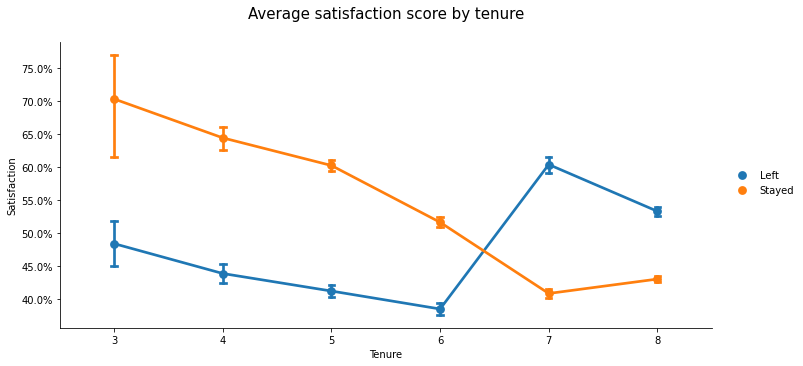

Figure 4


In [ ]:

g= sns.catplot(data=df[(df.tenure>2)&(df.tenure<9)],
               y= "satisfaction",x="tenure",
               kind="point", 
               hue="left_label",
               capsize=0.05, 
               ci=95,
               aspect=2,
               estimator=np.mean,
               n_boot=10000,
               seed=42,
               legend=False)
                
plt.title("Average satisfaction score by tenure\n", fontdict=dict(size=15))
g.add_legend()
g.map_dataframe(ticks_percent)
plt.ylabel("Satisfaction")
plt.xlabel("Tenure")
plt.show()
plt.show()
print('\033[1m' + 'Figure 4' + '\033[0m')

It is intuitive to think that higher satisfaction would reduce turnover. 

If we look at tenures 7 and 8  (combined), the top half scores had a turnover rate of **61 %** and the bottom half 18 %. So the turnover rate is higher among the happier workers, for this subset.

For tenures 6 and below, we see the opposite.
<br>Turnover rate was higher for the ones that scored above the median, in the satisfaction survey, by **39** p.p. (4.2% vs 43.4%) 

**Figure 5** compares turnover rate splitting each tenure group by its median satisfaction score, which was 46% for [7,8] and 54% for tenures 6 or less.

**Turnover rate by tenure**

In [ ]:
cols=defaultdict(list)
tenures = [[8],[7],[7,8],[3,4,5,6]]
list_median =[df.loc[(df.tenure.isin(x)),"satisfaction"].median() for x in tenures]
list_data = [ [df.loc[(df.tenure.isin(x))&(df.satisfaction >list_median[i]),"left"],
               df.loc[(df.tenure.isin(x))&(df.satisfaction <list_median[i]),"left"]] for i,x in  enumerate(tenures)  ]


name = ["Tenure 8", "Tenure 7","Only [ 7,8 ]" ,"6 years or less"]
for d in range(4):
    # data0 represents satisfaction > median and data1 bellow median
    data0=list_data[d][0]
    data1=list_data[d][1]
    data = np.concatenate((data0,data1))
    obs=data0.mean()
    diff=obs- data1.mean()
    repre  = len(data0) / len(df)

    #p-value is calculated depending on the direction  
    if obs > data1.mean():
        stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="larger")
    else:
        stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="smaller")
    

    # feed the results into the dictionary

    cols["Tenure"].append(name[d])
    cols["p-value"].append(round(p,3))
    cols["Most satisfyed"].append(f"{data0.mean():.1%}")
    cols["Least satisfyed"].append(f"{data1.mean():.1%}")
    cols["difference"].append(f"{diff:+.1%}")
    cols["Representation (top satisfyed)"].append(f"{repre:.2%}")

    
# whole company    
median = df.satisfaction.median()

data0=df.loc[(df.satisfaction >median),"left"]
data1=df.loc[(df.satisfaction <median),"left"]


# Turnover rate for each group as well as the difference
obs=data0.mean()
diff=obs- data1.mean()
data = np.concatenate((data0,data1))
repre  = len(data0) / len(df)
#p-value is calculated depending on the direction  
if obs > data1.mean():
    stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="larger")
else:
    stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="smaller")

# feed the results into the dictionary

cols["Tenure"].append("Whole company")
cols["p-value"].append(round(p,3))
cols["Most satisfyed"].append(f"{data0.mean():.1%}")
cols["Least satisfyed"].append(f"{data1.mean():.1%}")
cols["difference"].append(f"{diff:+.1%}")
cols["Representation (top satisfyed)"].append(f"{repre:.2%}")

    
    
# use the dictionary to create a DataFrame
display(pd.DataFrame(cols).set_index("Tenure"))
print('\033[1m' + 'Figure 5' + '\033[0m')

,p-value,Most satisfyed,Least satisfyed,difference,Representation (top satisfyed)
Tenure,,,,,
Tenure 8,0.0,63.8%,23.4%,+40.4%,9.90%
Tenure 7,0.0,58.0%,16.6%,+41.4%,11.57%
"Only [ 7,8 ]",0.0,61.7%,18.7%,+43.0%,21.47%
6 years or less,0.0,4.2%,43.4%,-39.2%,24.69%
Whole company,0.0,28.1%,30.3%,-2.2%,50.00%


Figure 5


## Promoted

One of the factors that might influence turnover and/or satisfaction is promotion.

`promoted` variable tracks which employee was promoted in the previous 24 months.

- **3 %** of the employees got promotions.
- Marketing (**4.2 %**) and Finance (**4.7 %**) registered the biggest amount.
- Logistics (**1.9 %**) and IT (**2.2 %**) received the least amount of promotions. 
- Tenure 7 (**2.5 %**) and 8 (**2.5 %**) were bellow company rate, and tenure 3 above (**3.5 %**).


Turnover was bigger among the workers that didn't get a promotion (**29.5 %** vs **19.7 %**)

This effect is independent of tenure or departmnent.


**Turnover rate by tenure group**

In [ ]:

cols=defaultdict(list)
list_data =[df[df.tenure.isin(x)] for x in tenures]                  


name = ["Tenure 8", "Tenure 7","Only [ 7,8 ]" ,"First 6 years"]


for d in range(4):
    data_=list_data[d]
    # data0 represents  promoted and data1 not promoted
    data0=data_.loc[data_.promoted==1, "left"]
    data1=data_.loc[data_.promoted==0, "left"]

    # Turnover rate for each group as well as the difference
    obs=data0.mean()
    diff=obs- data1.mean()
    data = np.concatenate((data0,data1))
    
    #p-value is calculated depending on the direction  
    if obs > data1.mean():
        stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="larger")
    else:
        stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="smaller")

    # feed the results into the dictionary

    cols["Tenure"].append(name[d])
    cols["p-value"].append(round(p,3))
    cols["Turnover (promoted)"].append(f"{data0.mean():.1%}")
    cols["Turnover (not promoted)"].append(f"{data1.mean():.1%}")
    cols["difference"].append(f"{diff:+.1%}")

# whole company    
data_=list_data[d]

data0=df.loc[df.promoted==1, "left"]
data1=df.loc[df.promoted==0, "left"]

# Turnover rate for each group as well as the difference
obs=data0.mean()
diff=obs- data1.mean()
data = np.concatenate((data0,data1))

#p-value is calculated depending on the direction  
if obs > data1.mean():
    stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="larger")
else:
    stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="smaller")

# feed the results into the dictionary

cols["Tenure"].append("Whole company")
cols["p-value"].append(round(p,3))
cols["Turnover (promoted)"].append(f"{data0.mean():.1%}")
cols["Turnover (not promoted)"].append(f"{data1.mean():.1%}")
cols["difference"].append(f"{diff:+.1%}")

# use the dictionary to create a DataFrame
display(pd.DataFrame(cols).set_index("Tenure"))
print('\033[1m' + 'Figure 6' + '\033[0m')

,p-value,Turnover (promoted),Turnover (not promoted),difference
Tenure,,,,
Tenure 8,0.112,35.4%,43.8%,-8.4%
Tenure 7,0.104,29.8%,37.5%,-7.6%
"Only [ 7,8 ]",0.040,32.4%,40.4%,-8.0%
First 6 years,0.001,14.9%,24.1%,-9.2%
Whole company,0.000,19.7%,29.5%,-9.8%


Figure 6


## Salary

For confidentiality reasons, salary comes in three tiers: low, medium, high.

69% earn a median salary, 16 % high, and 14% low.

Support (18%) and Finance (17%) are the most likely to give high salaries. Logistics is the least likely (14.1%).

The least likely to give out low salaries is Admin (11 % ) the most likely is Marketing (17%)

We usually expect salary to influence a worker's satisfaction. 

<br>We can't say it doesn't,  but there is no evidence to suggest that it does. The distributions of satisfaction are not that different across different salaries.

But if we zoom in, there are some differences.

Workers at tenure 7 with a low salary have a 33% turnover rate, 4.6 p.p. lower than the higher paid ones (37.9%).
Workers at tenure 8 with a low salary  have a 46% turnover rate, 42.5%  for high salary (-3.9 p.p) and 43.2% for medium salaries (-3.2 p.p).

Workers at the company for 9 years are the most likely to be given a high salary (20%)

## Bonus

Another way to reward workers is with a bonus. 

21% of employees were rewarded with a bonus.

The admin department is the least likely to give a bonus (18%) and the Finance and Marketing departments are the most generous (22%).
Only 17% of the workers at the company for 3 years received a bonus.
While tenures 4 and 7 were the most rewarded at 22%.

No statistically significant result was found to suggest that bonus influences turnover. 

**Turnover rate by tenure group**

In [ ]:

cols=defaultdict(list)

for d in range(4):
    data_=list_data[d]
    # data0 represents  promoted and data1 not promoted
    data0=data_.loc[data_.bonus==1, "left"]
    data1=data_.loc[data_.bonus==0, "left"]

    # Turnover rate for each group as well as the difference
    obs=data0.mean()
    diff=obs- data1.mean()
    data = np.concatenate((data0,data1))
    
    #p-value is calculated depending on the direction  
    if obs > data1.mean():
        stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="larger")
    else:
        stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="smaller")

    # feed the results into the dictionary

    cols["Tenure"].append(name[d])
    cols["p-value"].append(round(p,3))
    cols["Turnover (bonus)"].append(f"{data0.mean():.1%}")
    cols["Turnover (no bonus)"].append(f"{data1.mean():.1%}")
    cols["difference"].append(f"{diff:+.1%}")

# whole company    
data_=list_data[d]

data0=df.loc[df.bonus==1, "left"]
data1=df.loc[df.bonus==0, "left"]

# Turnover rate for each group as well as the difference
obs=data0.mean()
diff=obs- data1.mean()
data = np.concatenate((data0,data1))

#p-value is calculated depending on the direction  
if obs > data1.mean():
    stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="larger")
else:
    stat,p= pzt(count=data0.sum(),nobs= len(data0), value=data1.mean(), alternative="smaller")

# feed the results into the dictionary

cols["Tenure"].append("Whole company")
cols["p-value"].append(round(p,3))
cols["Turnover (bonus)"].append(f"{data0.mean():.1%}")
cols["Turnover (no bonus)"].append(f"{data1.mean():.1%}")
cols["difference"].append(f"{diff:+.1%}")

# use the dictionary to create a DataFrame
display(pd.DataFrame(cols).set_index("Tenure"))
print('\033[1m' + 'Figure 6' + '\033[0m')

,p-value,Turnover (bonus),Turnover (no bonus),difference
Tenure,,,,
Tenure 8,0.091,41.0%,44.3%,-3.3%
Tenure 7,0.352,36.6%,37.4%,-0.8%
"Only [ 7,8 ]",0.100,38.5%,40.6%,-2.1%
First 6 years,0.154,22.7%,24.1%,-1.4%
Whole company,0.101,28.2%,29.5%,-1.3%


Figure 6


We expect to see rewards such as higher salaries, bonuses and pormotions to be given out based on merit. Among other reasons, and assuming the validity of the test, a performance review should help pick who to reward.

## Review 

`review` is the composite score the employee received in their last evaluation.(0-100%)

- In the company, the lowest review was 31%.
- Among the workers that stayed, the average review was 63%, with no practical significant influence by department or tenure. 

To spot a practically significant difference between each tenure, we have to split the ones that left from the ones that stayed. 

**Figure 7** Shows Average review by tenure along with 95% C.I. as vertical lines.

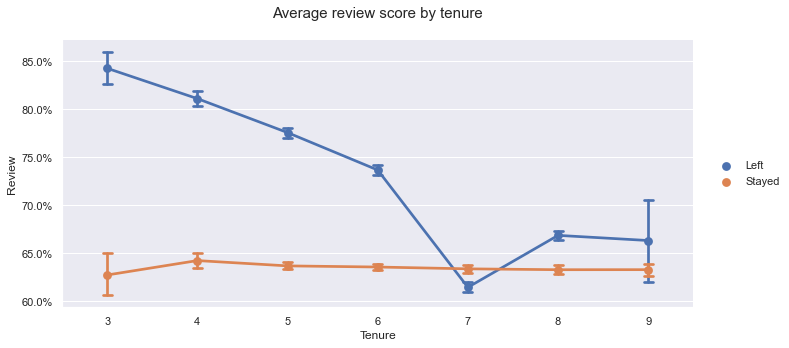

Figure 7


In [ ]:

_= sns.catplot(data=df[(df.tenure>2)&(df.tenure<10)], 
           y= "review",x="tenure", 
           kind="point", 
           hue="left_label",
           capsize=0.1, 
           ci=95,
           aspect=2, 
           estimator=np.mean,
           n_boot=10000,
           seed=42, legend=False)
plt.title("Average review score by tenure\n", fontdict=dict(size=15))
_.add_legend()
_.map_dataframe(ticks_percent)
plt.ylabel("Review")
plt.xlabel("Tenure")
plt.show()
print('\033[1m' + 'Figure 7' + '\033[0m')

Among the workers that left, tenure is inversely related to review scores. Spearman correlation is **-0.55**.

<br>For workers at the company for 6 years or less, the average review was **13** p.p. higher among the ones that left.
<br>Eventhoug tenure 7 was **1.9** p.p bellow, Conhens *d* is **-0.25**, considered a small effect.


**Turnover rate among top performers**

Assuming that the test is accurate enough in its capacity, I subsetted the top 25 % scores in a performance review for each tenure, and compared the turnover rates to the bottom 75 %.
<br> The results are shown in **Figure 8**.

There was a **53** % turnover rate for the top quarter compared to just 21 % for the rest of the company. 

Although the tenures 7 to 8 represent a high turnover, outside this group turnover among the top performers is **64%** compared to just **7.3%** for the remaining 3/4.

During the first 6 years, top performers (top quarter in review scores ), leave at a rate of  **69.4** %. Mostlly driven by logistics (74.6 %) and It (72.3 %). Admin was the least effected at 61.3 %.

**25** % of workers at the company for 3 years scored above 84 %. All of the 17 workers left.  

In [ ]:
print('\033[1m' + 'Turnover rate for high performers' + '\033[0m')
cols=defaultdict(list)
list_q3=[df.loc[(df.tenure.isin(x)),"review"].quantile(.75) for x in tenures]
list_data = [  [df.loc[(df.tenure.isin(x))&(df.review >list_q3[i]),"left"], 
                   df.loc[(df.tenure.isin(x))&(df.review <list_q3[i]),"left"]] for i,x in enumerate(tenures)]
for d in range(4):
    # data0 represents top 25 % performers and data1 the complement
    data0=list_data[d][0]
    data1=list_data[d][1]
    data = np.concatenate((data0,data1))
    obs=data0.mean()
    diff=obs- data1.mean()

    
    perm_replicates = draw_perm_reps(data0, data1, proportion, 10000)
    
    #p-value is calculated depending on the direction
    if obs > data.mean():
        p = np.sum(perm_replicates >= obs) / len(perm_replicates)
    else:
        p = np.sum(perm_replicates <= obs) / len(perm_replicates)
    

    # feed the results into the dictionary

    cols["Tenure"].append(name[d])
    cols["p-value"].append(round(p,3))
    cols["High performers"].append(f"{data0.mean():.1%}")
    cols["Others"].append(f"{data1.mean():.1%}")
    cols["difference"].append(f"{diff:+.1%}")

# Whole company
data0=df.loc[(df.review>df.review.quantile(.75)), "left"]
data1=df.loc[(df.review<df.review.quantile(.75)), "left"]
data = np.concatenate((data0,data1))
obs=data0.mean()
diff=obs- data1.mean()

perm_replicates = draw_perm_reps(data0, data1, proportion, 10000)
    
#p-value is calculated depending on the direction
if obs > data.mean():
    p = np.sum(perm_replicates >= obs) / len(perm_replicates)
else:
    p = np.sum(perm_replicates <= obs) / len(perm_replicates)



# feed the results into the dictionary

cols["Tenure"].append("Whole company")
cols["p-value"].append(round(p,3))
cols["High performers"].append(f"{data0.mean():.1%}")
cols["Others"].append(f"{data1.mean():.1%}")
cols["difference"].append(f"{diff:+.1%}")

# use the dictionary to create a DataFrame
display(pd.DataFrame(cols).set_index("Tenure"))
print('\033[1m' + 'Figure 8' + '\033[0m')

Turnover rate for high performers


,p-value,High performers,Others,difference
Tenure,,,,
Tenure 8,0.000,56.8%,39.2%,+17.6%
Tenure 7,0.007,32.8%,38.7%,-5.9%
"Only [ 7,8 ]",0.000,45.1%,38.5%,+6.6%
First 6 years,0.000,69.4%,8.6%,+60.8%
Whole company,0.000,53.7%,21.0%,+32.7%


Figure 8


Turnover among the top performers can be unrelated to the company. A competitive market creates a wider range of options for the best workers. 
<br>Still, turnover among the top performers is related to low satisfaction.

Looking at the workers that left, as review increases satisfaction decreases.

Top performers tend to leave less satisfied than others.


Figure 9


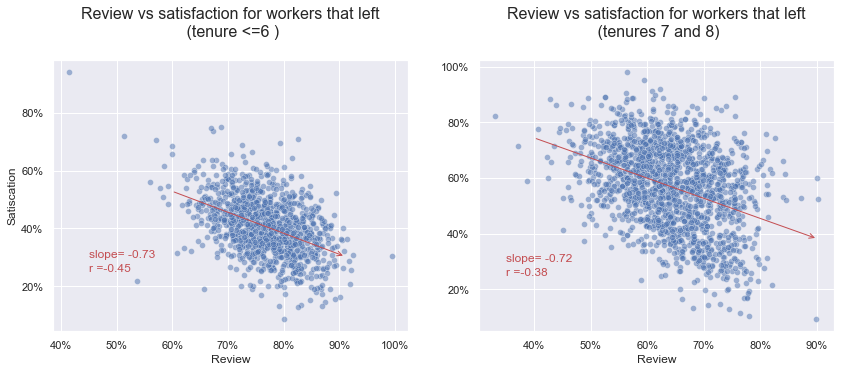

In [ ]:
sns.set(rc= {"figure.figsize": (14, 5)})
fig, axes = plt.subplots(1, 2)

data=df[(df.tenure.isin([3,4,5,6]))&(df.left==1)]
left=sns.scatterplot(data=data,
                x= "review",
                y="satisfaction",
                alpha=0.5, 
                ax=axes[0]
               )

res=stats.linregress(data.review,data.satisfaction )
x=np.array([0.6,0.91])
y= x*res[0]+ res[1]

axes[0].text(0.45,0.3, f"slope= {res[0]:.2f}",fontdict={"color":"r"})
axes[0].text(0.45,0.25, f"r ={res[2]:.2f}",fontdict={"color":"r"})
axes[0].annotate("",
            xy=(x[1], y[1]), xycoords='data',
            xytext=(x[0], y[0]), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color="r"),
            )
left.set_title('Review vs satisfaction for workers that left\n (tenure <=6 )\n', fontdict={"size":16})
left.set_xlabel('Review')
left.set_ylabel('Satiscation')
left.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
left.xaxis.set_major_formatter(mtick.PercentFormatter(1)) 
data=df[(df.tenure.isin([7,8]))&(df.left==1)]
right=sns.scatterplot(data=data,
            x= "review",
            y="satisfaction",
            alpha=0.5, 
            ax=axes[1]
             )
x=np.array([0.4,0.9])
res=stats.linregress(data.review,data.satisfaction )
y= x*res[0]+ res[1]
#axes[1].plot(x,y, color="r")
axes[1].annotate("",
            xy=(x[1], y[1]), xycoords='data',
            xytext=(x[0], y[0]), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color="r"),
            )
axes[1].text(0.35,0.3, f"slope= {res[0]:.2f}",fontdict={"color":"r"})
axes[1].text(0.35,0.25, f"r ={res[2]:.2f}",fontdict={"color":"r"})
right.set_xlabel('Review')
right.set_ylabel('')
right.set_title('Review vs satisfaction for workers that left\n (tenures 7 and 8)\n', fontdict={"size":16})
right.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
right.xaxis.set_major_formatter(mtick.PercentFormatter(1)) 
print('\033[1m' + 'Figure 9' + '\033[0m')
plt.show()

During the first 6 years:
- Turnover among promoted workers is 14% and 24 % for not promoted.
- For high performers, 2.8%  got a promotion, while for the rest the rate was 3.3 % 


## Projects 

One way to evaluate the number of responsibilities a worker is submitted to is using the number of projects each has been apart.

Workers are involved in either 2,3,4 or 5 projects.

Over two-thirds are included in 2 or 3 projects, independent of tenure or department.

As tenures increase the proportion of workers included in 4 or 5 projects increase: 29% for tenure 3, 32% for 8, and 34% for tenure 9.


The turnover rate was 4.1 p.p higher among workers at 4-5 projects (29% vs 33%). Mostly driven by the logistics department (+ 4.6 p.p.).

Within tenures 7 and 8, turnover was 38 % among workers envolved in 4 or 5 projects, and 41 % (-3 p.p.) for the ones in 2 or 3 projects. 
Workers involved in 4-5 projects are more likely to get bonuses in Support, IT, Engineering, Finance, Retail departments.


Workers seem as happier to be on 4 or 5 projects as they are to be on 2 or 3. 

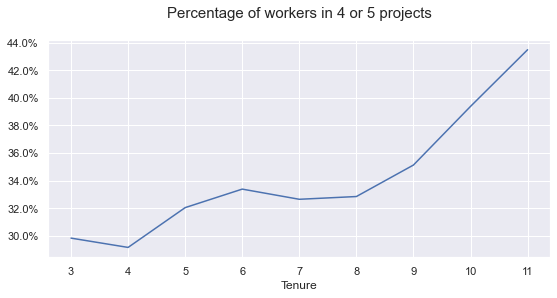

Figure 10


In [ ]:
sns.set(rc= {"figure.figsize": (9, 4)})
data=df.groupby("tenure").mean()[["4-5"]].iloc[1:-1,:].reset_index()
_=sns.lineplot(x=data.tenure, y= data["4-5"])
_.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
plt.title("Percentage of workers in 4 or 5 projects\n", fontdict=dict(size=15))
plt.ylabel("")
plt.xlabel("Tenure")
plt.show()
print('\033[1m' + 'Figure 10' + '\033[0m')

## Punch in n' out


It is expected that the longer you are at the company, the more responsibilities will fall into you.
<br>It seems that the longer workers stay at the company, the more hours they are expected to do. 
<br>For some, that challenge can be overwhelming.

`avg_hrs_month` tracks the average amount of hours that the employee has worked in a month.

<br>There is a 97.8 correlation between tenure and avg monthly working hours.

The min avg increases every time tenure increases. 

All departments average 184 hours a month.

Each box in **Figure 11** shows min and max montly average hours per tenure.

In [ ]:
print('\033[1m' + 'Spearman correlation between avg_hrs_month and tenure \n' + '\033[0m')
x =df.avg_hrs_month  
y =df.tenure
display(pg.corr(x,y,method="spearman"))

Spearman correlation between avg_hrs_month and tenure 



,n,r,CI95%,p-val,power
spearman,9540,0.978887,"[0.98, 0.98]",0.0,1.0


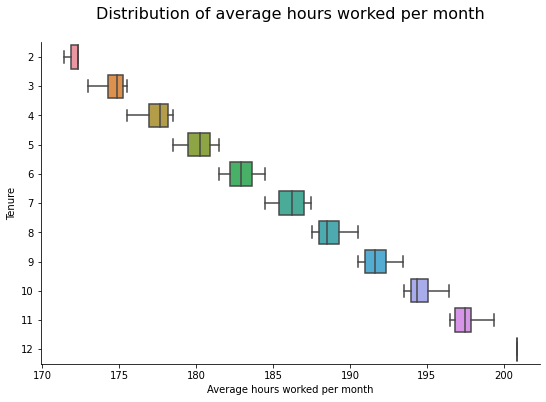

Figure 11


In [ ]:
_=sns.catplot(data=df,
            x= "avg_hrs_month",
            y="tenure",
            kind="box",
            orient="h",
            aspect=1.5,
            sym=""
           )
plt.title("Distribution of average hours worked per month\n", fontdict=dict(size=16))

plt.ylabel("Tenure")
plt.xlabel("Average hours worked per month")
plt.show()
print('\033[1m' + 'Figure 11' + '\033[0m')

To compare the difference in time spent working between the workers that left and the ones that stayed
we have to take into account that each tenure has completely different working habits. 

**Figure 12.a** shows that for tenure 7 workers that left tend to work, on average 35 min a month more. 
For tenure 8 the trend was the opposite, workers that left tend to work, on average 33 min a month less.

In [ ]:
print('\033[1m' + 'Difference in time spent working between the workers that left and the ones that stayed\n' + '\033[0m')
cols=defaultdict(list)

for dep in range(3,10):
  data0=df.loc[(df.tenure==dep)&(df.left==1), "avg_hrs_month"]
  data1=df.loc[(df.tenure==dep)&(df.left==0), "avg_hrs_month"]
  diff = diff_of_means(data0, data1)
  obs=  CohenEffectSize(data0,data1)
  
  if diff>0:
    stat, p=(stats.ranksums(data0, data1, alternative="greater" ))
  elif diff==0.0:
    print("DIFF IS 0!!! check if you used the same distribution")
    stat, p=(stats.ranksums(data0, data1))
  else:
    stat, p=(stats.ranksums(data0, data1, alternative="less" ))
  cols["Tenure"].append(dep)
  cols["Avg time worked (left)"].append(f"{data0.mean():.2f}")
  a= int(diff*60)
  cols["difference in minutes"].append(f"{a:+} min")
  cols["|"].append("|")
  cols["p-value"].append(round(p,3))
  cols["Conhen's d"].append(obs)
  cols["Size of the ones that left"].append(len(data0))

display(pd.DataFrame(cols))
print('\033[1m' + 'Figure 12.a' + '\033[0m')

Difference in time spent working between the workers that left and the ones that stayed



,Tenure,Avg time worked (left),difference in minutes,|,p-value,Conhen's d,Size of the ones that left
0,3,174.49,-20 min,|,0.069,-0.468053,30
1,4,177.34,-10 min,|,0.012,-0.223022,186
2,5,180.09,-6 min,|,0.008,-0.138746,428
3,6,182.88,-4 min,|,0.038,-0.086783,478
4,7,186.53,+35 min,|,0.000,0.698626,823
5,8,188.34,-33 min,|,0.000,-0.745315,823
6,9,191.59,-8 min,|,0.232,-0.163845,14


Figure 12.a


There is evidence to sugest that promoted workers, work longer hours.

In [ ]:
print('\033[1m' + 'Difference in time spent working between the promoted and not promoted workers\n' + '\033[0m')
cols=defaultdict(list)

for dep in range(3,10):
  data0=df.loc[(df.tenure==dep)&(df.promoted==1), "avg_hrs_month"]
  data1=df.loc[(df.tenure==dep)&(df.promoted==0), "avg_hrs_month"]
  diff = diff_of_means(data0, data1)
  obs=  CohenEffectSize(data0,data1)
  
  if diff>0:
    stat, p=(stats.ranksums(data0, data1, alternative="greater" ))
  elif diff==0.0:
    print("DIFF IS 0!!! check if you used the same distribution")
    stat, p=(stats.ranksums(data0, data1))
  else:
    stat, p=(stats.ranksums(data0, data1, alternative="less" ))
  cols["Tenure"].append(dep)
  cols["Avg time worked (promoted)"].append(f"{data0.mean():.2f}")
  a= int(diff*60)
  cols["difference in minutes"].append(f"{a:+} min")
  cols["|"].append("|")
  cols["p-value"].append(round(p,3))
  cols["Conhen's d"].append(obs)
  cols["Size of promoted "].append(len(data0))

display(pd.DataFrame(cols))
print('\033[1m' + 'Figure 12.b' + '\033[0m')

Difference in time spent working between the promoted and not promoted workers



,Tenure,Avg time worked (promoted),difference in minutes,|,p-value,Conhen's d,Size of promoted
0,3,174.74,+5 min,|,0.652,0.119222,2
1,4,177.21,-14 min,|,0.134,-0.309749,11
2,5,180.25,+4 min,|,0.209,0.094205,58
3,6,182.76,-10 min,|,0.023,-0.215126,83
4,7,185.82,-21 min,|,0.003,-0.396526,57
5,8,188.82,+9 min,|,0.099,0.201474,48
6,9,191.83,+6 min,|,0.314,0.126676,24


Figure 12.b


There is evidence to sugest that working in more projects increases the average monthly hours worked.

In [ ]:
print('\033[1m' + 'Difference in time spent working between the ones evolved in 4 or 5 projects and the ones involved in 2 or 3 \n' + '\033[0m')
cols=defaultdict(list)

for dep in range(3,10):
  data0=df.loc[(df.tenure==dep)&(df["4-5"]==1), "avg_hrs_month"]
  data1=df.loc[(df.tenure==dep)&(df["4-5"]==0), "avg_hrs_month"]
  diff = diff_of_means(data0, data1)
  obs=  CohenEffectSize(data0,data1)
  
  if diff>0:
    stat, p=(stats.ranksums(data0, data1, alternative="greater" ))
  elif diff==0.0:
    print("DIFF IS 0!!! check if you used the same distribution")
    stat, p=(stats.ranksums(data0, data1))
  else:
    stat, p=(stats.ranksums(data0, data1, alternative="less" ))
  cols["Tenure"].append(dep)
  cols["Avg time worked (4 or 5)"].append(f"{data0.mean():.2f}")
  a= int(diff*60)
  cols["difference in minutes"].append(f"{a:+} min")
  cols["|"].append("|")
  cols["p-value"].append(round(p,3))
  cols["Conhen's d"].append(obs)
  cols["Size of 4 or 5 "].append(len(data0))

display(pd.DataFrame(cols))
print('\033[1m' + 'Figure 12.c' + '\033[0m')

Difference in time spent working between the ones evolved in 4 or 5 projects and the ones involved in 2 or 3 



,Tenure,Avg time worked (4 or 5),difference in minutes,|,p-value,Conhen's d,Size of 4 or 5
0,3,174.78,+10 min,|,0.282,0.243987,17
1,4,177.45,+0 min,|,0.457,-0.005508,151
2,5,180.17,+0 min,|,0.501,-0.004513,584
3,6,182.92,-1 min,|,0.227,-0.033065,772
4,7,186.15,-1 min,|,0.277,-0.019326,721
5,8,188.67,+0 min,|,0.346,0.017523,620
6,9,191.65,-7 min,|,0.034,-0.149864,203


Figure 12.c


As tenure increase, average monthly hours also increase.
This phenomenon has little effect on the turnover rate until workers pass 185 hours a month.
The only workers, doing more than 190 hours a month are the ones at the company for 9 years or more.

At tenure 7, workers start to do more than 185 hours/month. 

<br>Turnover rate bellow 185 hours / month is **23** %   but between 185 and 190 is **43** %. Within this range, workers leave less and less satisfied as the amount of hours worked at a rate of less **10** % in satisfaction score per hour increased. 



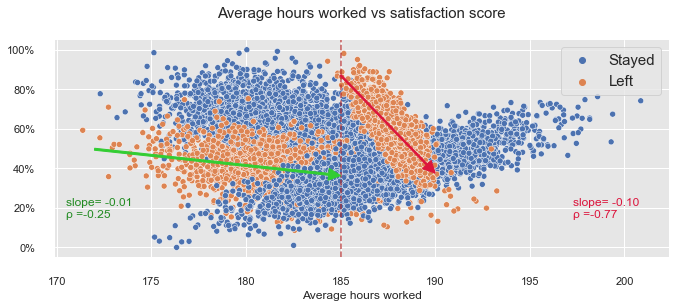

Figure 13
ρ : Pearson correlation coefficient


In [ ]:
sns.set(rc= {"figure.figsize": (11, 4)})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
data=df.copy()
data["left_"] = df.left
data.left_.replace({1:"Left" , 0: "Stayed"}, inplace=True)
gfg=sns.scatterplot(data=data,y= "satisfaction",x="avg_hrs_month",hue="left_")
gfg.legend(fontsize=15)

# To construct a prettier line I'll use 85 % of the data 
x=np.array([184,189])
y=np.array([0.8,0.2])
m =(y[1]-y[0])/(x[1]-x[0])
b= abs((m*x[0])-y[0])
""""
data= df[(df.left==1)&(df.avg_hrs_month>184)&(df.avg_hrs_month<191)]
gfg=sns.scatterplot(data=data,y= "satisfaction",x="avg_hrs_month")
y1= x*m + b
plt.plot(x,y1)
plt.show()
"""
data["satisfaction_"]= df.avg_hrs_month*m+b
condition= data.satisfaction > data.satisfaction_
data1= data[(data.left==1)&(data.avg_hrs_month>184)&(data.avg_hrs_month<191)&condition]
x=np.array([185,190 ])
res=stats.linregress(data1.avg_hrs_month,data1.satisfaction )
y= x*res[0]+ res[1]


plt.annotate("",xy=(x[1], y[1]), 
             xycoords='data',
             xytext=(x[0], y[0]), textcoords='data',
             arrowprops=dict(width=1.5,
                            color="crimson",
                            ),
            )



plt.text(197.3,0.21, f"slope= {res[0]:.2f}",fontdict={"color":"crimson"})
plt.text(197.3,0.15, f"\N{GREEK SMALL LETTER RHO} ={res[2]:.2f}",fontdict={"color":"crimson"})
#-------------------------------------------------------------------------------------

data= df[(df.left==1)&(df.avg_hrs_month<185)]

x=np.array([172,185 ])
res=stats.linregress(data.avg_hrs_month,data.satisfaction )
y= x*res[0]+ res[1]

plt.annotate("",
            xy=(x[1], y[1]), xycoords='data',
            xytext=(x[0], y[0]), textcoords='data',
            arrowprops=dict(width=2, color="limegreen"),
            )

plt.text(170.5,.21, f"slope= {res[0]:.2f}",fontdict={"color":"forestgreen"})
plt.text(170.5,0.15, f"\N{GREEK SMALL LETTER RHO} ={res[2]:.2f}",fontdict={"color":"forestgreen"})



#  -------------     /      ----------------        / ------------



plt.axvline(185, linestyle="--", alpha=0.75, color="firebrick")

# Preify

sns.despine(offset=10, trim=True);
plt.title("Average hours worked vs satisfaction score\n", fontdict=dict(fontsize=15))
plt.xlabel("Average hours worked")
plt.ylabel("", rotation=0)
gfg.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
plt.show()
print('\033[1m' + 'Figure 13' + '\033[0m')
print(f"\N{GREEK SMALL LETTER RHO} : Pearson correlation coefficient")

Before tenure 7, there is a negative correlation between hours worked and review score, among workers that left. 
<br> That is because the company is losing its high performers at every tenure.

**Figure 8** emphasizes that average review among the workers that left declines over tenure, that is because the best performers at the early tenures never get to the next. This effect continues until tenure 7. 

The reason could be external. 

Still, once workers start to dedicate more than 185 hours a month, that effect is no longer a concern. **Figure 9** shows that turnover among high performers is lower than the bottom 75%. 

Above 185 hours a month, as the number of hours worked increases, so does the review score of the ones that left, with a Person correlation of 0.63. Wanting more hours out of the workers at this stage might increase the chance of turnover among high performers. 

Also, for workers averaging less than 185 hours/month, the top **25** % performers all have a score higher than 72 %. But after 7 to 8 years, when 43 % of them leaves, tenure 9 and over have a lower performing top. Here only 13 % manage to score higher than 72 % in the evaluation.


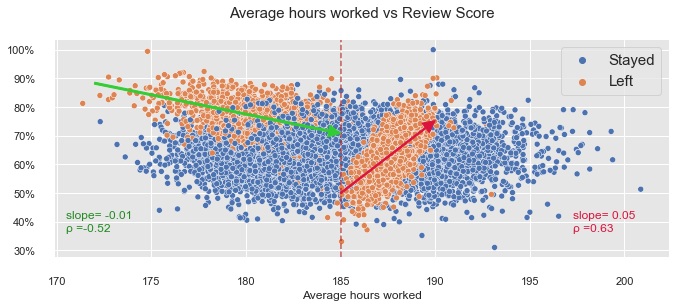

Figure 14
ρ : Pearson correlation coefficient


In [ ]:
sns.set(rc= {"figure.figsize": (11, 4)})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
data=df.copy()
data["left_"] = df.left
data.left_.replace({1:"Left" , 0: "Stayed"}, inplace=True)
gfg=sns.scatterplot(data=data,y= "review",x="avg_hrs_month",hue="left_")
gfg.legend(fontsize=15)


# pretier line
x=np.array([184,188])
y=np.array([0.4,0.9])
m =(y[1]-y[0])/(x[1]-x[0])
b= abs((m*x[0])-y[0])
"""
data=df.copy()
data= df[(df.left==1)&(df.avg_hrs_month>184)&(df.avg_hrs_month<191)]
gfg=sns.scatterplot(data=data,y= "review",x="avg_hrs_month")

y1= x*m - b
plt.plot(x,y1)
plt.show()
"""
data["review_"]= df.avg_hrs_month*m-b
condition= data.review < data.review_

# regression line parameters

data= df[(df.left==1)&(df.avg_hrs_month>184)&(df.avg_hrs_month<191)&condition]
x=np.array([185,190 ])
res=stats.linregress(data.avg_hrs_month,data.review )
y= x*res[0]+ res[1]

# plot the regression line

plt.annotate("",xy=(x[1], y[1]), 
             xycoords='data',
             xytext=(x[0], y[0]), textcoords='data',
             arrowprops=dict(width=1.5,
                            color="crimson",
                            ),
            )


# text slope and intercept
plt.text(197.3,0.41, f"slope= {res[0]:.2f}",fontdict={"color":"crimson"})
plt.text(197.3,0.365, f"\N{GREEK SMALL LETTER RHO} ={res[2]:.2f}",fontdict={"color":"crimson"})
#-------------------------------------------------------------------------------------
# Data < 185


# regression line parameters
data= df[(df.left==1)&(df.avg_hrs_month<185)]

x=np.array([172,185 ])
res=stats.linregress(data.avg_hrs_month,data.review )
y= x*res[0]+ res[1]


# plot the regression line
plt.annotate("",
            xy=(x[1], y[1]), xycoords='data',
            xytext=(x[0], y[0]), textcoords='data',
            arrowprops=dict(width=2, color="limegreen"),
            )

# text slope and intercept
plt.text(170.5,.41, f"slope= {res[0]:.2f}",fontdict={"color":"forestgreen"})
plt.text(170.5,0.365, f"\N{GREEK SMALL LETTER RHO} ={res[2]:.2f}",fontdict={"color":"forestgreen"})



#  -------------     /      ----------------        / ------------


# 185 vertical line
plt.axvline(185, linestyle="--", alpha=0.75, color="firebrick")

# Preify

sns.despine(offset=10, trim=True);
plt.title("Average hours worked vs Review Score\n", fontdict=dict(fontsize=15))
plt.xlabel("Average hours worked")
plt.ylabel("", rotation=0)
gfg.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
plt.show()
print('\033[1m' + 'Figure 14' + '\033[0m')
print(f"\N{GREEK SMALL LETTER RHO} : Pearson correlation coefficient")